In [ ]:
import os
os.chdir('..')
import time
import numpy as np
import networkx as nx
import torch
import src.pytorch_graph_edit_networks as gen
import src.hep_th as hep_th
import src.college_msg as college_msg
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## HEP-TH Dataset

In [1]:
'''
HEP TH
'''

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model parameters
num_layers = 20
dim_hid = 128
nonlin = torch.nn.Tanh()
max_past = 3
# Save function for saving the Model
def save_state(model_save_path):
    state = {
    "model": net.state_dict(),
    "optimizer": optimizer.state_dict(),
    "train_loss": train_loss,
    "valid_loss": val_loss
    }
    torch.save(obj=state, f=model_save_path)
# set up a list of all experimental settings
month_tuples = []
for year in range(1992,2003+1):
    max_month = 4
    if year == 2003:
        max_month = 4
    for month in range(1, max_month+1):
        month_tuples.append((year, month))
settings = []
for past in range(1, max_past+1):
    for t in range(past, len(month_tuples)):
        settings.append((month_tuples[t][0], month_tuples[t][1], past))
val_settings=[]
for past in range(5,5+max_past + 1):
    for t in range(past, len(month_tuples)):
        val_settings.append((month_tuples[t][0], month_tuples[t][1], max_past))
# initialize a new network
net = gen.GEN(num_layers = num_layers, dim_in = 1, dim_hid = dim_hid, nonlin = nonlin, filter_edge_edits = False,non_markovian=True).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.0001)
train_loss = []
val_loss = []
for epoch in range(1,1000):
    last_past = -1
    running_loss = 0.0
    for s in range(len(settings)):
        optimizer.zero_grad()
        year, month, past = settings[s]
        if past != last_past:
            print('considering %d past months for graph construction' % past)
            last_past = past
            last_s = s
        # compute a forward pass for loss computation
        loss = hep_th.compute_loss(net, year, month, past = past).to(device)
        # compute gradient
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if s%50==0:
            print('[%d, %5d] loss: %.3f' %
                  (epoch, s + 1, running_loss / 50))
            train_loss.append(running_loss/50)
            running_loss=0.0
            valid_loss = 0.0
            net.eval()
            print("Validation Graph Construction")
            for vs in range(len(val_settings)):
                year, month, past = val_settings[vs]
                loss = hep_th.compute_loss(net, year, month, past=past).to(device)
                valid_loss += loss.item()
            print("Valid loss: %.3f" % (valid_loss/len(val_settings)))
            val_loss.append((valid_loss/len(val_settings)))
    save_state(os.path.abspath('graph-edit-networks/hep-th/modelHEP.pt'))
plt.plot(train_loss,c='g')
plt.plot(val_loss,c='r')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.show()
plt.savefig(os.path.abspath('graph-edit-networks/hep-th/LossCurveHEP.png'))

        


considering 1 past months for graph construction
[1,     1] loss: 50.493
Validation Graph Construction


KeyboardInterrupt: 

In [24]:
def load_state(save_path, model, optimizer, train_loss, validation_loss):
    state = torch.load(save_path,map_location=torch.device('cpu'))
    model.load_state_dict(state["model"])
    optimizer.load_state_dict(state["optimizer"])
    train_loss = state["train_loss"]
    validation_loss = state["valid_loss"]
    return model, optimizer, train_loss, validation_loss


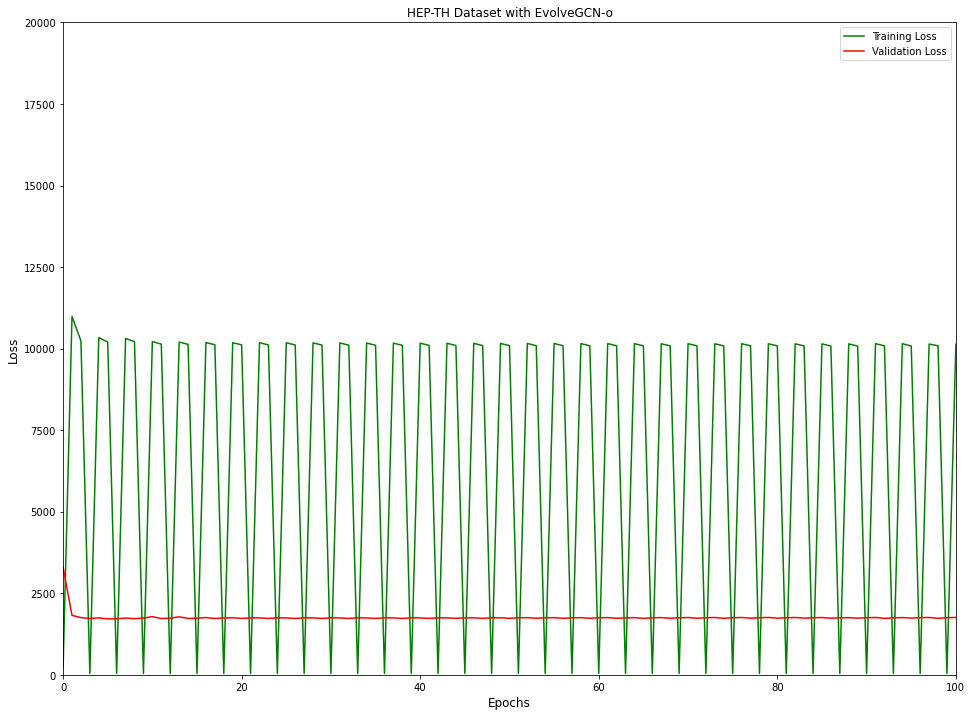

In [25]:
'''
Load the EvolveGCN-o Model and plot the loss of the model.
'''
train_loss = []
validation_loss = []
net = gen.GEN(num_layers = num_layers, dim_in = 1, dim_hid = dim_hid, nonlin = nonlin, filter_edge_edits = False,non_markovian=True)
optimizer = optim.Adam(net.parameters(), lr=0.0001)
pat = "Models/modelHEP_past3_month4_EVOLVEGCN_new.pt"
model,optimizer,train_loss,validation_loss=load_state(pat,net,optimizer,train_loss,validation_loss)
plt.figure(figsize=(16,12))
plt.plot(train_loss,c='g')
plt.plot(validation_loss,c='r')
plt.title("HEP-TH Dataset with EvolveGCN-o")
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.ylim(0,20000)
plt.xlim(0,100)
plt.show()

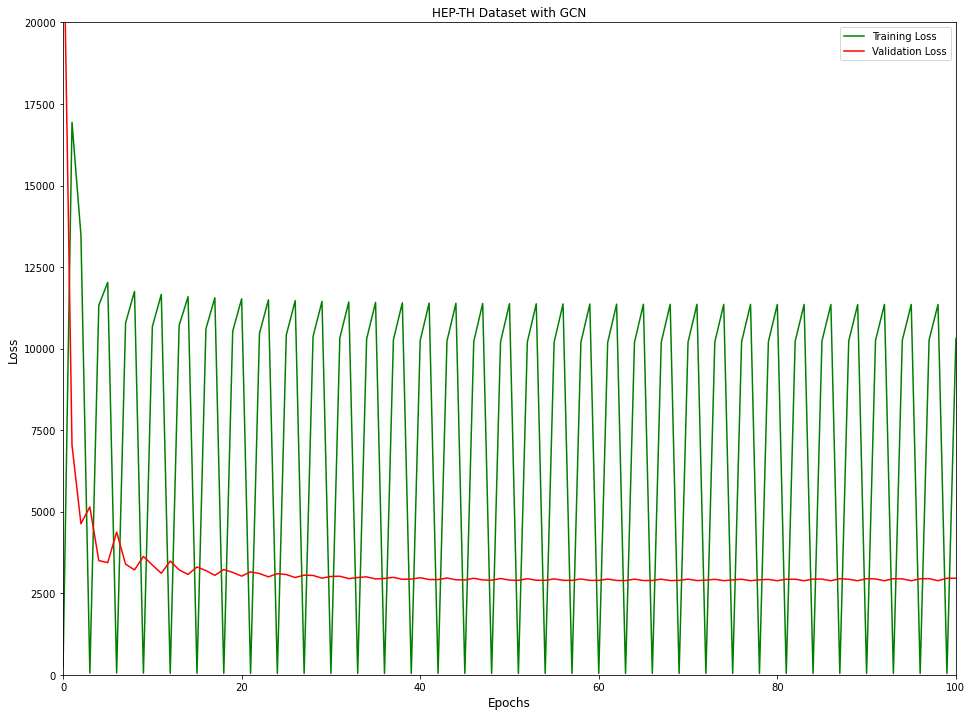

In [26]:
'''
Load the GCN Model and plot the loss of the model
'''
train_loss = []
validation_loss = []
net = gen.GEN(num_layers = num_layers, dim_in = 1, dim_hid = dim_hid, nonlin = nonlin, filter_edge_edits = False,non_markovian=False)
optimizer = optim.Adam(net.parameters(), lr=0.0001)
pat = "Models/modelHEP_past3_month4_GCN.pt"
model,optimizer,train_loss,validation_loss=load_state(pat,net,optimizer,train_loss,validation_loss)
plt.figure(figsize=(16,12))
plt.plot(train_loss,c='g')
plt.plot(validation_loss,c='r')
plt.title("HEP-TH Dataset with GCN")
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.ylim(0,20000)
plt.xlim(0,100)
plt.show()

## College-MSG Dataset

In [27]:
'''
COLLEGE MSG
'''


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load data
df = pd.read_csv(os.path.abspath("data/CollegeMsg.txt"), sep=' ', header = None, names=['From','To','Time'])
df.Time = pd.to_datetime(df.Time, infer_datetime_format=True, unit='s')
df.index = df.Time

# Model saving function
def save_state(model_save_path):
    state = {
    "model": net.state_dict(),
    "optimizer": optimizer.state_dict(),
    "train_loss": train_loss,
    "valid_loss": val_loss
  }
    torch.save(obj=state, f=model_save_path)
# model parameters
num_layers = 2
dim_hid = 64
nonlin = torch.nn.Tanh()
max_past = 7
# set up a list of all experimental settings
day_tuples = []
max_month = 5
month_dict = {4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31}
for month in range(5, max_month+1):
    for day in range(1,month_dict[month]+1):
        day_tuples.append((2004, month, day))

settings = []
for past in range(1, max_past+1):
    for t in range(past, len(day_tuples)):
        settings.append((day_tuples[t][0], day_tuples[t][1],day_tuples[t][2], past))
val_settings=[]
for t in range(1, max_past+1):
    val_settings.append((day_tuples[t][0], day_tuples[t][1],day_tuples[t][2], max_past))

# initialize a new network
net = gen.GEN(num_layers = num_layers, dim_in = 1, dim_hid = dim_hid, nonlin = nonlin, filter_edge_edits = False, non_markovian=True).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.0001)
train_loss = []
val_loss = []
for epoch in range(1,100):
    last_past = -1
    running_loss = 0.0
    print(epoch)
    for s in range(len(settings)):
        optimizer.zero_grad()
        year, month, day, past = settings[s]
        if past != last_past:
            print('considering %d past days for graph construction' % past)
            last_past = past
            last_s = s
        # compute a forward pass for loss computation
        loss = college_msg.compute_loss(net,df, year, month, day, past = past).to(device)
        # compute gradient
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if s%50==0:
            print('[%d, %5d] loss: %.3f' %
                  (epoch, s + 1, running_loss / 50))
            train_loss.append(running_loss/50)
            running_loss=0.0
            valid_loss = 0.0
            net.eval()
            for vs in range(len(val_settings)):
                year, month, day, past = val_settings[vs]
                loss = college_msg.compute_loss(net,df, year, month, day, past = past).to(device)
                valid_loss += loss.item()
            print("Valid loss: %.3f" % (valid_loss/len(val_settings)))
            val_loss.append((valid_loss/len(val_settings)))
    save_state(os.path.abspath('graph-edit-networks/data/modelMSG7DaysOnly_5days.pt'))
        


1
considering 1 past days for graph construction


KeyboardInterrupt: 

In [28]:
'''
Load function to load the model, optmizer, validation loss and training loss.
'''
def load_state(save_path, model, optimizer, train_loss, validation_loss):
    state = torch.load(save_path,map_location=torch.device('cpu'))
    model.load_state_dict(state["model"])
    optimizer.load_state_dict(state["optimizer"])
    train_loss = state["train_loss"]
    validation_loss = state["valid_loss"]
    return model, optimizer, train_loss, validation_loss


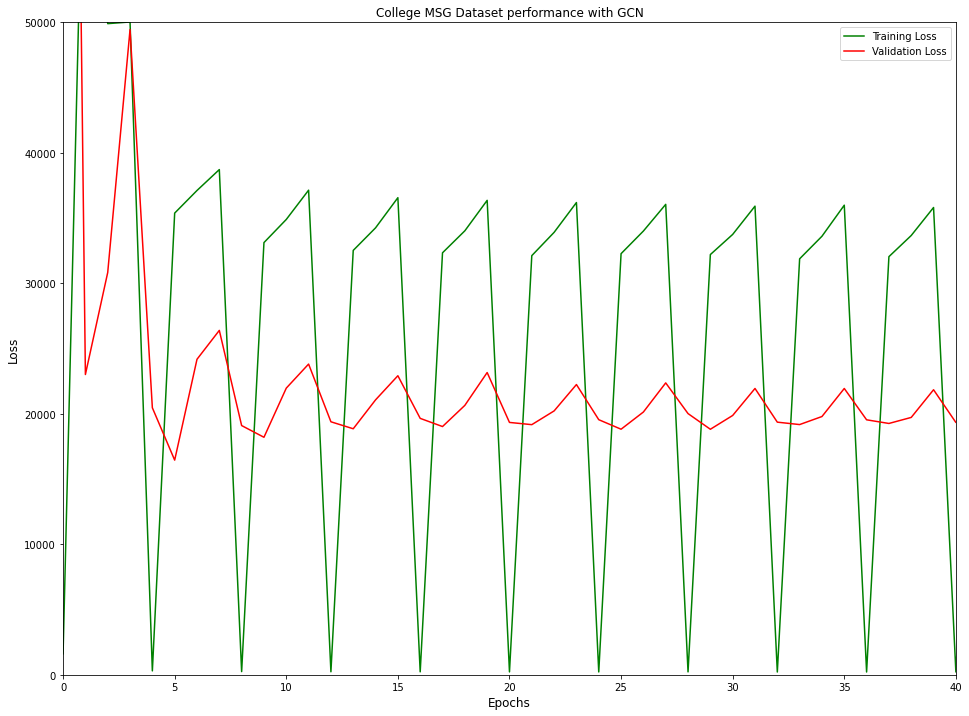

In [29]:
'''
Loading the GCN model and plotting the loss
'''
train_loss = []
validation_loss = []
net = gen.GEN(num_layers = 2, dim_in = 1, dim_hid = dim_hid, nonlin = nonlin, filter_edge_edits = False,non_markovian=False)
optimizer = optim.Adam(net.parameters(), lr=0.0001)
pat = "Models/modelMSG_max_month5_max_past_7_GCN.pt"
net,optimizer,train_loss,validation_loss=load_state(pat,net,optimizer,train_loss,validation_loss)
plt.figure(figsize=(16,12))
plt.plot(train_loss,c='g')
plt.plot(validation_loss,c='r')
plt.legend(['Training Loss', 'Validation Loss'])
plt.title("College MSG Dataset performance with GCN")
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.ylim(0,50000)
plt.xlim(0,40)
plt.show()

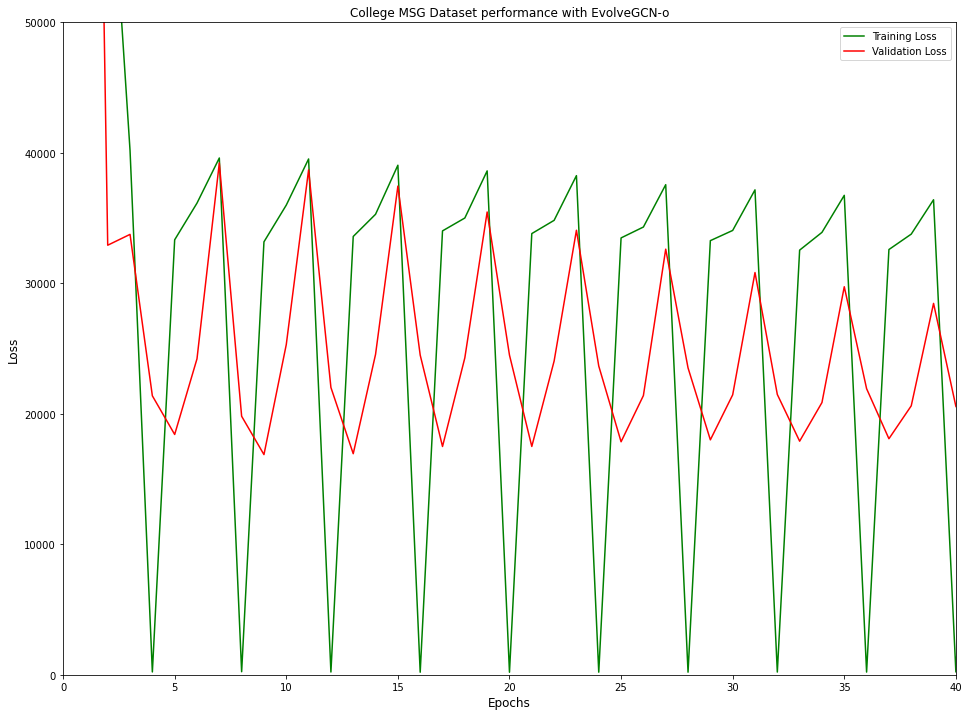

In [30]:
'''
Loading the EvolveGCN-o model and plotting the loss
'''
train_loss = []
validation_loss = []
net = gen.GEN(num_layers = 2, dim_in = 1, dim_hid = dim_hid, nonlin = nonlin, filter_edge_edits = False,non_markovian=True)
optimizer = optim.Adam(net.parameters(), lr=0.0001)
pat = "Models/modelMSG_max_month5_max_past_7_EGCN.pt"
net,optimizer,train_loss,validation_loss=load_state(pat,net,optimizer,train_loss,validation_loss)
plt.figure(figsize=(16,12))
plt.plot(train_loss,c='g')
plt.plot(validation_loss,c='r')
plt.legend(['Training Loss', 'Validation Loss'])
plt.title("College MSG Dataset performance with EvolveGCN-o")
plt.ylim(0,50000)
plt.xlim(0,40)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.show()